<a href="https://colab.research.google.com/github/aq1048576/COS217_A2/blob/master/Canny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def gaussianKernel(sigma):
    """\
    creates gaussian kernel  with sigma and length 6*sigma +1
    """
    len= 3 * sigma #6*sigma+1
    linespace = np.linspace(-(len - 1) / 2., (len - 1) / 2., len)
    const = 1/(np.sqrt(2*np.pi)*sigma)
    oneD=const*(np.e**(-(linespace**2)/(2*sigma**2)))
   
    return oneD

def derGaussianKernel(sigma):
    """\
    creates derivative gaussian kernel  with sigma and length 6*sigma +1
    """
    ## option one. just calculate it straight from 
    len= 3*sigma #6*sigma+1
    linespace = np.linspace(-(len - 1) / 2., (len - 1) / 2., len)
    const = -1/(np.sqrt(2*np.pi)*sigma**3)
    ans= const*linespace*np.e**(-linespace**2/(2*sigma**2))
    return ans

def filteredGradient(im, sigma):
    # Computes the smoothed horizontal and vertical gradient images for a given
    # input image and standard deviation. The convolution operation should use
    # 0 padding.
    #
    # im: 2D float32 array with shape (height, width). The input image.
    # sigma: double. The standard deviation of the gaussian blur kernel.

    # Returns:
    # Fx: 2D double array with shape (height, width). The horizontal
    #     gradients.
    # Fy: 2D double array with shape (height, width). The vertical
    #     gradients.
   
    print('img shape', im.shape)
    img_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    cv2.imwrite("grayscale.jpg", im)
    im = img_gray/255.0
    print('img gray shape', im.shape)
    #line = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    #kx1 = np.exp(-0.5 * (np.square(xx)) / np.square(sig))

    #kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    #kx1 = cv2.gaussian()
    #Fx = scipy.ndimage.gaussian_filter(im, sigma, order=(1,0), cval = 0.0)
    #Fy = scipy.ndimage.gaussian_filter(im, sigma, order=(0,1), cval = 0.0)

    gaussianFilter = gaussianKernel(sigma)
    derGaussianFilter = derGaussianKernel(sigma)

    gaussianX=np.expand_dims(gaussianFilter,0)
    gaussianY=np.expand_dims(gaussianFilter,1)

    devGausX= np.expand_dims(derGaussianFilter,0)
    devGausY= np.expand_dims(derGaussianFilter,1)
    print('dim devGausX', devGausX.shape)
    print('dim Gaus Y', gaussianY.shape)
    print('im shape', im.shape,'devGaus', devGausX.shape)
    Fx =  cv2.filter2D(im, -1, devGausX ) #devGausX
    print('first Fx', Fx.shape)
    Fx =  cv2.filter2D(Fx, -1, gaussianY)
    print('sec Fx', Fx.shape)
    Fy =   cv2.filter2D(im,-1, devGausY)
    Fy=  cv2.filter2D(Fy,  -1, gaussianX)
    plt.imshow(Fx)
    plt.imshow(Fy)
    plt.show()
    return Fx, Fy

In [4]:
def edgeStrengthAndOrientation(Fx, Fy):
    # Given horizontal and vertical gradients for an image, computes the edge
    # strength and orientation images.
    #
    # Fx: 2D double array with shape (height, width). The horizontal gradients.
    # Fy: 2D double array with shape (height, width). The vertical gradients.

    # Returns:
    # F: 2D double array with shape (height, width). The edge strength
    #        image.
    # D: 2D double array with shape (height, width). The edge orientation
    #        image.
    F = np.sqrt(np.multiply(Fx, Fx)+ np.multiply(Fy, Fy))
    D = np.arctan(Fy, Fx)
    print('d shape',D.shape)
    print('D range',np.min(D), np.max(D))
    D = np.where(D <0, np.pi+D, D) #added this
    plt.imshow(F)
    plt.show()
    return F, D

In [5]:
import math
def suppression(F, D):
    print('in suppresion')
    # Runs nonmaximum suppression to create a thinned edge image.
    #
    # F: 2D double array with shape (height, width). The edge strength values
    #    for the input image.
    # D: 2D double array with shape (height, width). The edge orientation
    #    values for the input image.

    # Returns:
    # I: 2D double array with shape (height, width). The output thinned
    #        edge image.

    #  this was code that was in the for loop. i changed it cuz it was hard to 
    # follow but you can put it back
    # '''  if ((0 <= D[i][j] < math.pi/8) or (7*math.pi/8 <= D[i][j] <math.pi)):
    #    if (F[i+1][j+1]>F[i][j+1] and F[i+1][j+1]> F[i+2][j+1]):
    #       I[i][j] = F[i+1][j+1]
    #    elif ((math.pi/8 <= D[i][j]) and ( D[i][j] < 3*math.pi/8)):
    #        if (F[i+1][j+1]>F[i+2][j+2]) and (F[i+1][j+1] > F[i][j]):
    #          I[i][j] = F[i+1][j+1]
    #  elif ((3*math.pi/8 <= D[i][j]) < 5*math.pi/8):
    #      if (F[i+1][j+1]>F[i+1][j+2] and F[i+1][j+1] > F[i+1][j]):
    #        I[i][j] = F[i+1][j+1]
                #    else:
                #      if (F[i+1][j+1]>F[i][j+2] and F[i+1][j+1] > F[i+2][j]):
    #        I[i][j] = F[i+1][j+1]'''

    (H,W) = F.shape
    I = F.copy()
    print('f.shape', F.shape)
    # changed from np.pad(F,((1,1),(1,1)),0)
    print('f.shape', F.shape)
    for i in range(H):
      for j in range(W):
        if ((0 <= D[i][j] < math.pi/8) or (7*math.pi/8 <= D[i][j] <math.pi)):
          if i>0:
            if (F[i-1][j]>F[i][j]):
              I[i][j] = 0;
          if i<H-1:
            if (F[i+1][j]>F[i][j]):
              I[i][j] = 0;
        elif ((math.pi/8 <= D[i][j]) and (D[i][j] < 3*math.pi/8)):
          if (i>0 and j<W-1):
            if (F[i-1][j+1]>F[i][j]):
              I[i][j] = 0;
          if (i<H-1 and j>0):
             if (F[i+1][j-1]>F[i][j]):
               I[i][j] = 0;
        elif ((3*math.pi/8 <= D[i][j]) < 5*math.pi/8):
          if j>0:
             if (F[i][j-1]>F[i][j]):
               I[i][j] = 0;
          if j<W-1:
            if (F[i][j+1]>F[i][j]):
              I[i][j] = 0;
        else:
          if (i>0 and j >0):
             if (F[i-1][j-1]>F[i][j]):
               I[i][j] = 0;
          if (i<H-1 and j>W-1):
            if (F[i+1][j+1]>F[i][j]):
              I[i][j] = 0;
    plt.imshow(I, cmap = 'gray', interpolation = 'bicubic')
    plt.show()
    return I

In [6]:
def hysteresisThresholding(I, D, tL, tH):
    print('in hystersis')
    # Runs hysteresis thresholding on the input image.

    # I: 2D double array with shape (height, width). The input's edge image
    #    after thinning with nonmaximum suppression.
    # D: 2D double array with shape (height, width). The edge orientation
    #    image.
    # tL: double. The low threshold for detection.
    # tH: double. The high threshold for detection.

    # Returns:
    # edgeMap: 2D binary array with shape (height, width). Output edge map,
    #          where edges are 1 and other pixels are 0. 
    #Create a list of pixels LaTeX: (x, y) such that LaTeX: I(x,y) > T_h.
    xqueue = []
    yqueue = []
    I = I/np.max(I)
    H,W = I.shape
    print(I.shape)
    edgeMap = np.zeros((H, W), dtype = float)
    visited = np.zeros((H, W), dtype = bool)
    for  i in range(H):
      for j in range(W):
        if I[i][j]>= tH:
          xqueue.append(i)
          yqueue.append(j)
          edgeMap[i][j] = 1
          visited[i][j]=True

    while (len(xqueue)>0):
      i = xqueue.pop(0)
      j = yqueue.pop(0)

      if ((3*math.pi/8 <= D[i][j]) < 5*math.pi/8):
          if i < H-1:
           if (I[i+1][j]>= tL and not (visited[i+1][j])):
            xqueue.append(i+1)
            yqueue.append(j)
            edgeMap[i+1][j] = 1
           visited[i+1][j] = True
          if i >0:  
           if (I[i-1][j]>= tL and not (visited[i-1][j])):
            xqueue.append(i-1)
            yqueue.append(j)
            edgeMap[i-1][j] = 1
          visited[i-1][j] = True

      elif ((math.pi/8 <= D[i][j]) < 5*math.pi/8): # orientation pi/4 check corners
        if ((i < H-1) and (j<W-1)):
          if (I[i+1][j+1]>= tL and not (visited[i+1][j+1])):
            xqueue.append(i+1)
            yqueue.append(j+1)
            edgeMap[i+1][j+1] = 1
          visited[i+1][j+1] = True
        if ((i>0) and (j>0)):
          if (I[i-1][j-1]>= tL and not(visited[i][j])):
            xqueue.append(i-1)
            yqueue.append(j-1)
            edgeMap[i-1][j-1] = 1
          visited[i-1][j-1] = True
            
      elif ((0 <= D[i][j] ) and (D[i][j]< math.pi/8)) or (7*math.pi/8 <= D[i][j] and (D[i][j]<math.pi)):
         if j<W-1:
          if (I[i][j+1]>= tL and not(visited[i][j+1])):
            xqueue.append(i)
            yqueue.append(j+1)
            edgeMap[i][j+1] = 1
         visited[i][j+1] = True
         if j>0:    
          if (I[i][j-1]>= tL and not(visited[i][j-1])):
            xqueue.append(i)
            yqueue.append(j-1)
            edgeMap[i][j-1] = 1
          visited[i][j-1] = True

      else: #3pi/4
         if ((i<H-1) and (j>0)):
          if (I[i+1][j-1]>= tL and not(visited[i+1][j-1])): 
            xqueue.append(i+1)
            yqueue.append(j-1)
            edgeMap[i+1][j-1] = 1
          visited[i+1][j-1] = True
         if  ((i>0) and (j<W-1)):   
          if (I[i-1][j+1]>= tL and not(visited[i-1][j+1])):
            xqueue.append(i-1)
            yqueue.append(j+1)
            edgeMap[i-1][j+1] = 1
         visited[i-1][j+1] = True
    edgeMap = edgeMap * 255       
    return edgeMap

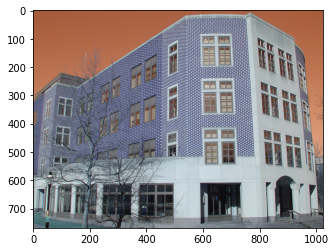

img shape (768, 1024, 3)
img gray shape (768, 1024)
dim devGausX (1, 15)
dim Gaus Y (15, 1)
im shape (768, 1024) devGaus (1, 15)
first Fx (768, 1024)
sec Fx (768, 1024)


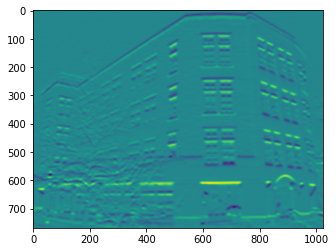


(768, 1024)
(768, 1024)
d shape (768, 1024)
D range -0.027523227002342464 0.031760161282587664


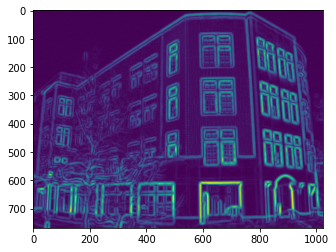

in suppresion
f.shape (768, 1024)
f.shape (768, 1024)


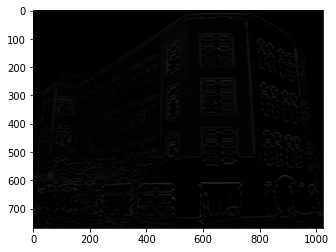

in hystersis
(768, 1024)


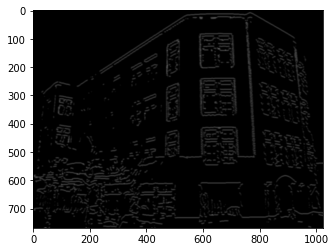

edgemap size (768, 1024)
bincount 4585665.0


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
def cannyEdgeDetection(im, sigma, tL, tH):
    # Runs the canny edge detector on the input image. This function should
    # not duplicate your implementations of the edge detector components. It
    # should just call the provided helper functions, which you fill in.
    #
    # IMPORTANT: We have broken up the code this way so that you can get
    # better partial credit if there is a bug in the implementation. Make sure
    # that all of the work the algorithm does is in the proper helper
    # functions, and do not change any of the provided interfaces. You
    # shouldn't need to create any new .py files, unless they are for testing
    # these provided functions.
    # 
    # im: 2D double array with shape (height, width). The input image.
    # sigma: double. The standard deviation of the gaussian blur kernel.
    # tL: double. The low threshold for detection.
    # tH: double. The high threshold for detection.

    # Returns:
    # edgeMap: 2D binary image of shape (height, width). Output edge map,
    #          where edges are 1 and other pixels are 0.


    # TODO: Implement me!
    #plt.imshow(im)
    #plt.show()
    Fx, Fy = filteredGradient(im, sigma)
    print()
    print(Fx.shape)
    print(Fy.shape)
    F,D = edgeStrengthAndOrientation(Fx, Fy)
    I = suppression(F, D)
    edgeMap = hysteresisThresholding(I, D, tL, tH)
    plt.imshow(edgeMap, cmap = 'gray', interpolation = 'bicubic')
    plt.show()
    print('edgemap size', edgeMap.shape)
    print('bincount', np.sum(edgeMap))
    return edgeMap
im = cv2.imread("csbldg.jpeg")
plt.imshow(im)
plt.show()
cannyEdgeDetection(im,5,0.01,.2)

In [8]:
def notHysteresisThresholding(I, D, tL, tH):
    # Runs hysteresis thresholding on the input image.

    # I: 2D double array with shape (height, width). The input's edge image
    #    after thinning with nonmaximum suppression.
    # D: 2D double array with shape (height, width). The edge orientation
    #    image.
    # tL: double. The low threshold for detection.
    # tH: double. The high threshold for detection.

    # Returns:
    # edgeMap: 2D binary array with shape (height, width). Output edge map,
    #          where edges are 1 and other pixels are 0. 
    I = I/np.max(I)
    H,W = I.shape
    np.pad(I, ((1,1),(1,1)),'constant', constant_values=(0,)) # whats the point of padding? 
    print(I.shape) 
    xqueue = []
    yqueue = []
    edgeMap = np.zeros((H, W), dtype = float)
    processed = np.zeros((H+2, W+2), dtype = bool)
    for  i in range(H):
      for j in range(W):
        if I[i+1][j+1]>= tH:
          processed[i+1][j+1] = True
          xqueue.append(i)
          yqueue.append(j)
          edgeMap[i][j] = 1
          
    while (not xqueue.empty()):
      i = xqueue.pop
      j = yqueue.pop
      if ((0 <= D[i][j] < math.pi/8) or (7*math.pi/8 <= D[i][j] <math.pi)):
          if (I[i+2][j+1]>= tL and not (processed[i+2][j+1])):
            xqueue.append(i+1)
            yqueue.append(j)
            processed[i+2][j+1] = True
            edgeMap[i+1][j] = 1
          if (I[i][j+1]>= tL and not (processed[i][j+1])):
            xqueue.append(i-1)
            yqueue.append(j)
            processed[i][j+1] = True
            edgeMap[i-1][j] = 1
      elif ((math.pi/8 <= D[i][j]) < 3*math.pi/8):
          if (I[i+2][j+2]>= tL and not (processed[i+2][j+2])):
            xqueue.append(i+1)
            yqueue.append(j+1)
            processed[i+2][j+2] = True
            edgeMap[i+1][j+1] = 1
          if (I[i][j]>= tL and not(processed[i][j])):
            xqueue.append(i-1)
            yqueue.append(j-1)
            processed[i][j] = True
            edgeMap[i-1][j-1] = 1
      elif ((3*math.pi/8 <= D[i][j]) < 5*math.pi/8):
          if (I[i+1][j+2]>= tL and not(processed[i+1][j+2])):
            xqueue.append(i)
            yqueue.append(j+1)
            processed[i+1][j+2] = True
            edgeMap[i][j+1] = 1
          if (I[i+1][j]>= tL and not(processed[i+1][j])):
            xqueue.append(i)
            yqueue.append(j-1)
            processed[i+1][j] = True
            edgeMap[i][j-1] = 1
      else:
          if (I[i+2][j]>= tL and not(processed[i+2][j])):
            xqueue.append(i+1)
            yqueue.append(j-1)
            processed[i+2][j] = True
            edgeMap[i+1][j-1] = 1
          if (I[i][j+2]>= tL and not(processed[i][j+2])):
            xqueue.append(i-1)
            yqueue.append(j+1)
            processed[i][j+2] = True
            edgeMap[i-1][j+1] = 1
    plt.plot(edgeMap)
    plt.plot(I)
    plt.show()
    return edgeMap

In [9]:
import math
def notSuppression(F, D):
    print('in suppresion')
    # Runs nonmaximum suppression to create a thinned edge image.
    #
    # F: 2D double array with shape (height, width). The edge strength values
    #    for the input image.
    # D: 2D double array with shape (height, width). The edge orientation
    #    values for the input image.

    # Returns:
    # I: 2D double array with shape (height, width). The output thinned
    #        edge image.

    #  this was code that was in the for loop. i changed it cuz it was hard to 
    # follow but you can put it back
    # '''  if ((0 <= D[i][j] < math.pi/8) or (7*math.pi/8 <= D[i][j] <math.pi)):
    #    if (F[i+1][j+1]>F[i][j+1] and F[i+1][j+1]> F[i+2][j+1]):
    #       I[i][j] = F[i+1][j+1]
    #    elif ((math.pi/8 <= D[i][j]) and ( D[i][j] < 3*math.pi/8)):
    #        if (F[i+1][j+1]>F[i+2][j+2]) and (F[i+1][j+1] > F[i][j]):
    #          I[i][j] = F[i+1][j+1]
    #  elif ((3*math.pi/8 <= D[i][j]) < 5*math.pi/8):
    #      if (F[i+1][j+1]>F[i+1][j+2] and F[i+1][j+1] > F[i+1][j]):
    #        I[i][j] = F[i+1][j+1]
    #    else:
    #      if (F[i+1][j+1]>F[i][j+2] and F[i+1][j+1] > F[i+2][j]):
    #        I[i][j] = F[i+1][j+1]'''

    (H,W) = F.shape
    print('H,W',H,W)
    Dstar = F.copy()
    print('f.shape', F.shape)
    np.pad(F,((1,1),(1,1)),'constant', constant_values=(0,)) # changed from np.pad(F,((1,1),(1,1)),0)
    print('f.shape', F.shape)
    I = np.zeros((H, W)) # changed from  np.zeros((H, W))
    for i in range(H):
      for j in range(W):
        if ((0 <= D[i][j] < math.pi/8) or (7*math.pi/8 <= D[i][j] <math.pi)):
          Dstar[i][j]=0
          '''if (F[i+1][j+1]>F[i][j+1] and F[i+1][j+1]> F[i+2][j+1]):
            I[i][j] = F[i+1][j+1]'''
        elif ((math.pi/8 <= D[i][j]) and ( D[i][j] < 3*math.pi/8)):
          Dstar[i][j]=math.pi/4
          '''if (F[i+1][j+1]>F[i+2][j+2]) and (F[i+1][j+1] > F[i][j]):
              I[i][j] = F[i+1][j+1]'''
        elif ((3*math.pi/8 <= D[i][j]) < 5*math.pi/8):
          Dstar[i][j]=math.pi/2
          '''if (F[i+1][j+1]>F[i+1][j+2] and F[i+1][j+1] > F[i+1][j]):
            I[i][j] = F[i+1][j+1]'''
        else:
          Dstar[i][j]=3*math.pi/4
          '''if (F[i+1][j+1]>F[i][j+2] and F[i+1][j+1] > F[i+2][j]):
            I[i][j] = F[i+1][j+1]'''

    for i in range(H):
      for j in range(W):
          #check left
          if j > 0:
              if F[i][j] < Dstar[i][j-1]:
                I[i][j]=0
                continue
          #check right
          if j < W-1:
            if F[i][j] < Dstar[i][j+1]:
               I[i][j]=0
               continue
          #check up
          if i > 0:
            if F[i][j] < Dstar[i-1][j]:
               I[i][j]=0
               continue
          #check down
          if i < H-1:
            if F[i][j] < Dstar[i+1][j]:
               I[i][j]=0
               continue
          I[i][j]=F[i][j]
    plt.imshow(I, cmap = 'gray', interpolation = 'bicubic')
    plt.show()
    return I